In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [3]:
import re
from collections import Counter

words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
#words = re.sub(r"^[a-z0-9]", " ", text.lower()).split()
#print(words[:30])

In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
vocab_to_int['the']

0

In [34]:
import random
import math
# The final subsampled word list
train_words = []
for word in int_words[:2]:
    p_word = 1- math.sqrt(0.8/((words.count(word)+1)/len(int_words)))
    if random.random() > p_word:
        train_words.append(word)
#train_words[:30]

In [80]:
from collections import Counter
import random

threshold = 1e-5
print(threshold)
threshold_1 = 0.9
word_counts = Counter(int_words) #index:count
#total_count = len(int_words)

#freqs = {word: count/total_count for word, count in word_counts.items()}
#p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
#train_words = [word for word in int_words if random.random() < (1 - np.sqrt(threshold_1/((word_counts[word]+1)/total_count)))]
train_words = [word for word in int_words if random.random() < (np.sqrt(threshold_1/((word_counts[word]+1))))]


train_words[:30]

1e-05


[15067,
 362,
 25636,
 7573,
 24172,
 21148,
 15068,
 12060,
 734,
 14622,
 53722,
 26184,
 16456,
 53724,
 11815,
 58113,
 14777,
 6054,
 12297,
 12297,
 14497,
 4778,
 14497,
 258,
 5805,
 29372,
 6187,
 30,
 4778,
 10855]

In [81]:
len(train_words)

465911

In [82]:
''' Get a list of words in a window around an index. '''
def get_target(words, idx, window_size):
    r = random.randint(1,window_size)
    if idx < r:
        return words[idx+1:idx+r+1]
    elif idx > len(words)-r:
        return words[idx-r:idx]
    else:
        return words[idx-r:idx]+words[idx+1:idx+r+1]
print(get_target(int_words, 9, 5))
print(int_words[:15])

[194, 1, 3133, 45, 58, 127, 741, 476, 10571, 133]
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]


In [83]:
''' Create a generator of word batches as a tuple (inputs, targets) '''
def get_batches(words, batch_size, window_size=5):
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [84]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [85]:
n_vocab = len(int_to_vocab)
n_embedding = 300 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) # create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs)# use tf.nn.embedding_lookup to get the hidden layer output

In [86]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) 
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [87]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [88]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [90]:
epochs = 10
batch_size = 10000
window_size = 5

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 3/10 Iteration: 100 Avg. Training loss: 20.7543 0.1330 sec/batch
Epoch 5/10 Iteration: 200 Avg. Training loss: 20.0453 0.2128 sec/batch
Epoch 7/10 Iteration: 300 Avg. Training loss: 19.3654 0.4066 sec/batch
Epoch 9/10 Iteration: 400 Avg. Training loss: 18.7371 0.4275 sec/batch


In [91]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


In [92]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [93]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

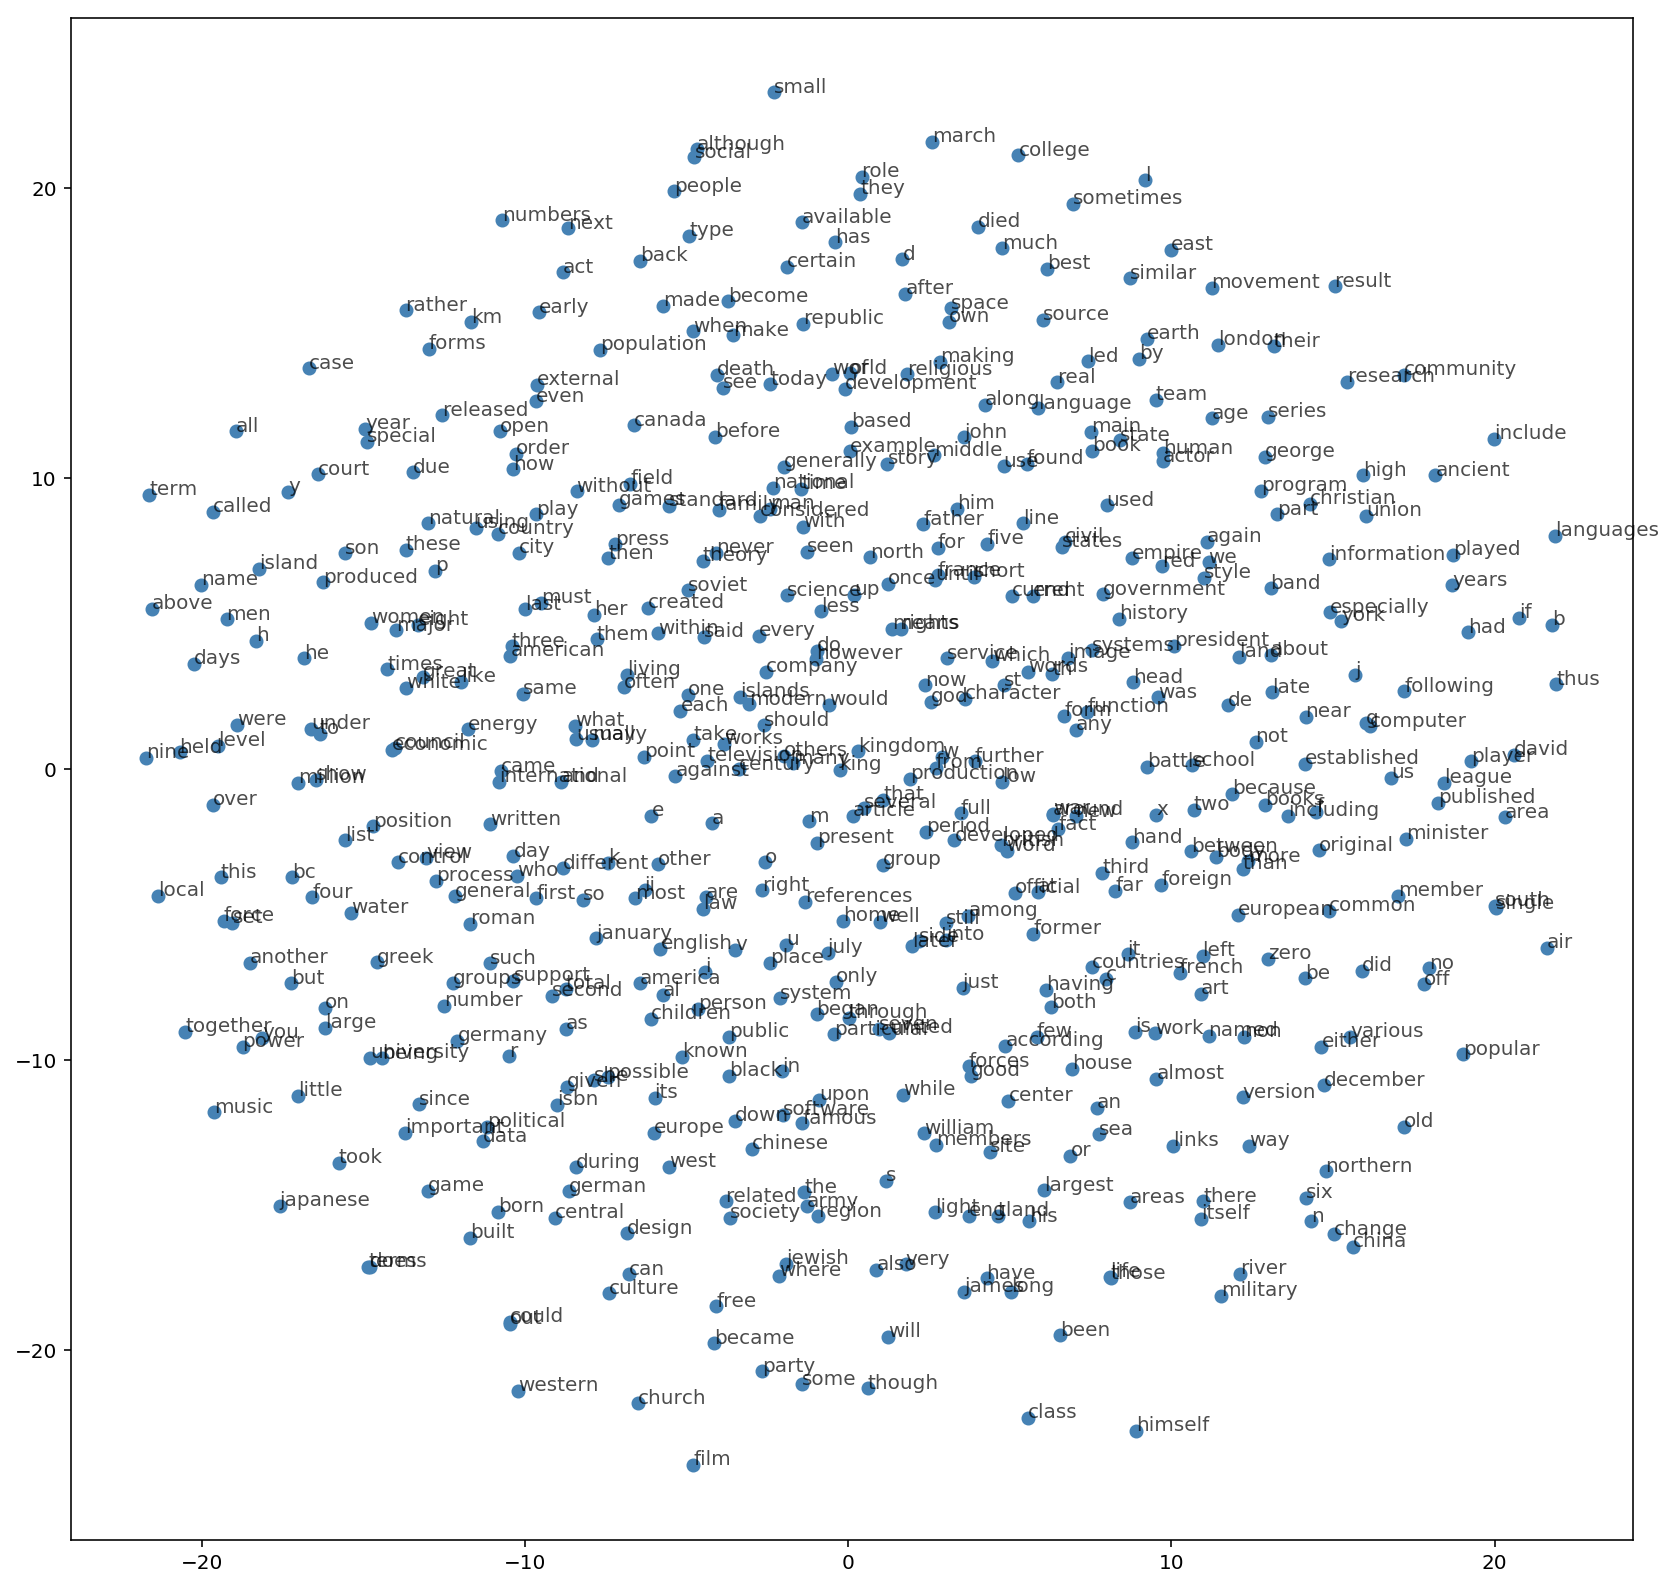

In [94]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)